In [1]:
import json
import csv
import os
import torch
import numpy as np
from sklearn.metrics import roc_curve, auc, confusion_matrix, f1_score, precision_recall_curve
from matplotlib import pyplot as plt
import matplotlib
from collections import defaultdict, OrderedDict

/home/yirui.wang/anaconda3/envs/rtnet/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
root = "/data/yirui/exps"

#### Collect all exp paths

In [10]:
all_exps = {}

# radiomics_paths = ["/home/yirui.wang/Desktop/MICCAI2023_radiomics.pth"]
# all_exps['Radiomics'] = radiomics_paths

# resnet50_paths = ['/data/yirui/exps/miccai_baseline/Resnet50_3d_add_mask_fold4/epoch_50/mobilenetv3_3d_miccai/predictions.txt']
# all_exps['ResNet50 w. LN mask'] = resnet50_paths

# resnet50_no_mask_paths = ["/data/yirui/exps/miccai_baseline_no_mask/resnet50_fold4/epoch_250/mobilenetv3_3d_miccai/predictions.txt"]
# all_exps['ResNet50 no mask'] = resnet50_no_mask_paths

# mnv2_paths = ["/data/yirui/exps/miccai_baseline/MobileNetv2_add_mask/fold0/epoch_250/mobilenetv3_3d_miccai/predictions.txt",
#               "/data/yirui/exps/miccai_baseline/MobileNetv2_add_mask/fold1/epoch_250/mobilenetv3_3d_miccai/predictions.txt",
#               "/data/yirui/exps/miccai_baseline/MobileNetv2_add_mask/fold2/epoch_250/mobilenetv3_3d_miccai/predictions.txt",
#               "/data/yirui/exps/miccai_baseline/MobileNetv2_add_mask/fold3/epoch_250/mobilenetv3_3d_miccai/predictions.txt",
#               "/data/yirui/exps/miccai_baseline/MobileNetv2_add_mask/fold3/epoch_250/mobilenetv3_3d_miccai/predictions.txt"]
# all_exps['MobileNetV2 w. LN mask'] = mnv2_paths

mnv2_no_mask_paths = ["/data/yirui/exps/miccai_baseline_no_mask/mobilenetv2_fold4/epoch_250/mobilenetv3_3d_miccai/predictions.txt"]
all_exps['Baseline (MobileNetV2)'] = mnv2_no_mask_paths


# mvit_paths = ["/data/yirui/exps/miccai_baseline/MobileViTv2_add_mask/fold0/epoch_250/mobilenetv3_3d_miccai/predictions.txt",
#               "/data/yirui/exps/miccai_baseline/MobileViTv2_add_mask/fold1/epoch_250/mobilenetv3_3d_miccai/predictions.txt",
#               "/data/yirui/exps/miccai_baseline/MobileViTv2_add_mask/fold2/epoch_250/mobilenetv3_3d_miccai/predictions.txt",
#               "/data/yirui/exps/miccai_baseline/MobileViTv2_add_mask/fold3/epoch_250/mobilenetv3_3d_miccai/predictions.txt",
#               "/data/yirui/exps/miccai_baseline/MobileViTv2_add_mask/fold4/epoch_250/mobilenetv3_3d_miccai/predictions.txt",]
# all_exps['MobileViTv2 w. LN mask'] = mvit_paths

# mvit_no_mask_paths = ["/data/yirui/exps/miccai_baseline_no_mask/mobilevitv2_fold4/epoch_250/mobilenetv3_3d_miccai/predictions.txt"]
# all_exps['MobileViTv2 no mask'] = mvit_no_mask_paths

# local_global_paths = ["/data/yirui/exps/miccai_local_global_add_mask/fold0/epoch_250/mobilenetv3_3d_miccai/predictions.txt",
#                       "/data/yirui/exps/miccai_local_global_add_mask/fold1/epoch_250/mobilenetv3_3d_miccai/predictions.txt",
#                       "/data/yirui/exps/miccai_local_global_add_mask/fold2/epoch_250/mobilenetv3_3d_miccai/predictions.txt",
#                       "/data/yirui/exps/miccai_local_global_add_mask/fold3/epoch_250/mobilenetv3_3d_miccai/predictions.txt",
#                       "/data/yirui/exps/miccai_local_global_add_mask/fold4/epoch_250/mobilenetv3_3d_miccai/predictions.txt"]
# all_exps['LMViT w. LN mask (ours)'] = local_global_paths

# local_global_no_mask_paths = ["/data/yirui/exps/miccai_baseline_no_mask/local_global_fold4/epoch_250/mobilenetv3_3d_miccai/predictions.txt"]
# all_exps['LMViT no mask (ours)'] = local_global_no_mask_paths

ours_paths = ["/data/yirui/exps/miccai_ours/local_global_fold0/epoch_250/mobilenetv3_3d_miccai/predictions.txt",
             "/data/yirui/exps/miccai_ours/local_global_fold1/epoch_250/mobilenetv3_3d_miccai/predictions.txt",
             "/data/yirui/exps/miccai_ours/local_global_fold2/epoch_250/mobilenetv3_3d_miccai/predictions.txt",
             "/data/yirui/exps/miccai_ours/local_global_fold3/epoch_250/mobilenetv3_3d_miccai/predictions.txt",
             "/data/yirui/exps/miccai_ours/local_global_fold4/epoch_250/mobilenetv3_3d_miccai/predictions.txt"]
all_exps['Ours'] = ours_paths

#### Calculate FPRs amd TPRs

In [11]:
all_curves = OrderedDict()
for tag, paths in all_exps.items():
    fprs, tprs, thres_all = [], [], []
    cv_per_LNS_results = []
    preds, labels = [], []
    auc_scores = []

    for results_path in paths:
        # load prediction txt file
        if not results_path.endswith(".pth"):
            with open(results_path, 'r') as f:
                results = f.read().splitlines()
        else:
            rdmics_preds = torch.load(results_path)
            rdmics_preds['test_fns'] = rdmics_preds['test_fns'].tolist()
            rdmics_preds['pred'] = rdmics_preds['pred'].tolist()
            rdmics_preds['label'] = rdmics_preds['label'].tolist()
            results = []
            for fname, pred, label in zip(rdmics_preds['test_fns'], rdmics_preds['pred'], rdmics_preds['label']):
                results.append("{},{},{}".format(fname.split('/')[1], int(label), pred))

        # save per station prediction results
        per_LNS_results = defaultdict(list)
        for item in results:
            fname, label, logit = item.split(',')
            LNS_name = fname.split('_')[1]
            per_LNS_results[LNS_name].append([int(label), float(logit)])
        cv_per_LNS_results.append(per_LNS_results)
        
        # gather all (stations) predictions and labels
        all_results = np.concatenate([val for key, val in per_LNS_results.items()], axis=0)
        
        # calculate metrics
        fpr, tpr, thres = roc_curve(all_results[:, 0], all_results[:, 1])
        fprs.append(fpr)
        tprs.append(tpr)
        thres_all.append(thres)
        preds.append(all_results[:, 1])
        labels.append(all_results[:, 0])
        
        roc_auc = auc(fpr, tpr)
        auc_scores.append(roc_auc)
        # print("AUROC score is {:.4f}".format(roc_auc))
        thres_at_spec_idx = np.argmin(np.abs(fpr - 0.05))
        def sigmoid(x):
            return 1 / (1 + np.exp(-x))
        print("Thres is {} @ spec=0.9".format(sigmoid(thres[thres_at_spec_idx])))

    fpr_grid = np.linspace(0.0, 1.0, 500)
    # Interpolate all ROC curves at these points
    mean_tpr = np.zeros_like(fpr_grid)

    for i in range(len(fprs)):
        mean_tpr += np.interp(fpr_grid, fprs[i], tprs[i])  # linear interpolation

    # Average it and compute AUC
    mean_tpr /= len(fprs)

    fpr_macro = fpr_grid
    tpr_macro = mean_tpr
    roc_auc_marco = auc(fpr_macro, tpr_macro)
    print("{} - averaged AUC is {:.4f}".format(tag, roc_auc_marco))

    for r_cutoff in [70, 75, 80, 85]:
        s_at_recall_idx = np.argmin(np.abs(tpr_macro - r_cutoff / 100.0))
        s_at_recall = 1 - fpr_macro[s_at_recall_idx]
        print("{} - S@Recall{} = {:.4f}".format(tag, r_cutoff, s_at_recall))

    for s_cutoff in [70, 75, 80, 85]:
        r_at_spec_idx = np.argmin(np.abs((1 - fpr_macro) - s_cutoff / 100.0))
        r_at_spec = tpr_macro[r_at_spec_idx]
        print("{} - R@Spec{} = {:.4f}".format(tag, s_cutoff, r_at_spec))

    all_curves[tag] = (fpr_macro, tpr_macro, roc_auc_marco)

Thres is 0.777272208113605 @ spec=0.9
Baseline (MobileNetV2) - averaged AUC is 0.8097
Baseline (MobileNetV2) - S@Recall70 = 0.7715
Baseline (MobileNetV2) - S@Recall75 = 0.7114
Baseline (MobileNetV2) - S@Recall80 = 0.6553
Baseline (MobileNetV2) - S@Recall85 = 0.6192
Baseline (MobileNetV2) - R@Spec70 = 0.7584
Baseline (MobileNetV2) - R@Spec75 = 0.7114
Baseline (MobileNetV2) - R@Spec80 = 0.6309
Baseline (MobileNetV2) - R@Spec85 = 0.4899
Thres is 0.16457531136082504 @ spec=0.9
Thres is 0.8313938878344761 @ spec=0.9
Thres is 0.7316282548649868 @ spec=0.9
Thres is 0.19953710683670647 @ spec=0.9
Thres is 0.9089969784597017 @ spec=0.9
Ours - averaged AUC is 0.8574
Ours - S@Recall70 = 0.8457
Ours - S@Recall75 = 0.8196
Ours - S@Recall80 = 0.7735
Ours - S@Recall85 = 0.7134
Ours - R@Spec70 = 0.8603
Ours - R@Spec75 = 0.8303
Ours - R@Spec80 = 0.7719
Ours - R@Spec85 = 0.6900


#### Draw curves WITH LN MASK

Baseline (MobileNetV2)
Ours


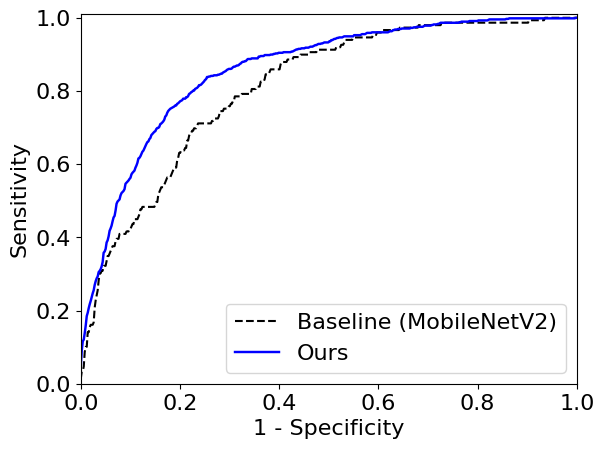

In [18]:
# line_colors = ['#38C5C9', '#FFF2B0', '#F0AC6E', '#929BA8', '#008891', '#CC2630']
# line_type = ['--', '--', '--', '--', '-', '-']
# lw = [2, 2, 2, 2, 2, 2.5]
line_colors = ['black', 'blue']
line_type = ['--', '-']
lw = [1.5, 1.75]
matplotlib.rcParams.update({'font.size': 16})

plt.figure()

color_index = 0
for idx, key in enumerate(all_curves):
    # if "no mask" in key:
    #     continue
    # if 'LMViT w. LN mask' in key:
    #     continue
    print(key)
    fpr_macro, tpr_macro, roc_auc_marco = all_curves[key]
    # draw
    plt.plot(
        fpr_macro,
        tpr_macro,
        color=line_colors[color_index],
        linestyle=line_type[color_index],
        lw=lw[color_index],
        label="{}".format(key),
    )
    color_index += 1

plt.xlim([0.0, 1])
plt.ylim([0.0, 1.01])
plt.xlabel("1 - Specificity")
plt.ylabel("Sensitivity")
# plt.title(f"ROC curve of CNN LNS classification")
plt.legend(loc="lower right")
# plt.show()
plt.savefig('LNM_ROC.svg', dpi=300)

Radiomics
ResNet50 w. LN mask
MobileNetV2 w. LN mask
MobileViTv2 w. LN mask
LMViT w. LN mask (ours)
Ours


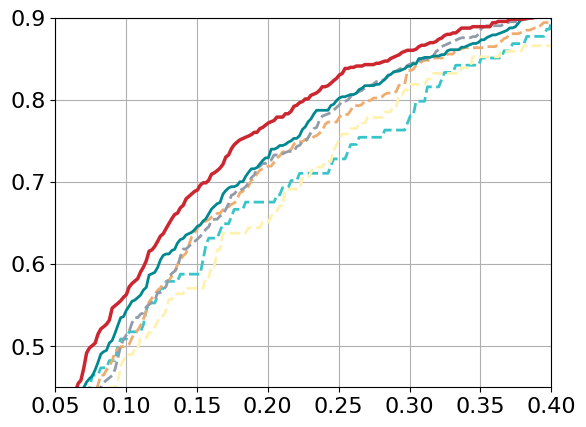

In [119]:
line_colors = ['#38C5C9', '#FFF2B0', '#F0AC6E', '#929BA8', '#008891', '#CC2630']
line_type = ['--', '--', '--', '--', '-', '-']
lw = [2, 2, 2, 2, 2, 2.5]
matplotlib.rcParams.update({'font.size': 16})

plt.figure()

color_index = 0
for idx, key in enumerate(all_curves):
    if "no mask" in key:
        continue
    # if 'LMViT w. LN mask' in key:
    #     continue
    print(key)
    fpr_macro, tpr_macro, roc_auc_marco = all_curves[key]
    # draw
    plt.plot(
        fpr_macro,
        tpr_macro,
        color=line_colors[color_index],
        linestyle=line_type[color_index],
        lw=lw[color_index],
        label="{}".format(key),
        
    )
    color_index += 1

plt.xlim([0.05, 0.4])
plt.ylim([0.45, 0.9])
plt.grid()
# plt.xlabel("1 - Specificity")
# plt.ylabel("Sensitivity")
# plt.title(f"ROC curve of CNN LNS classification")
# plt.legend(loc="lower right")
# plt.show()
plt.savefig('LNM_ROC_zoomin.svg', dpi=300)

#### Draw curves WITHOUT MASK

ResNet50 no mask
MobileNetV2 no mask
MobileViTv2 no mask
LMViT no mask (ours)


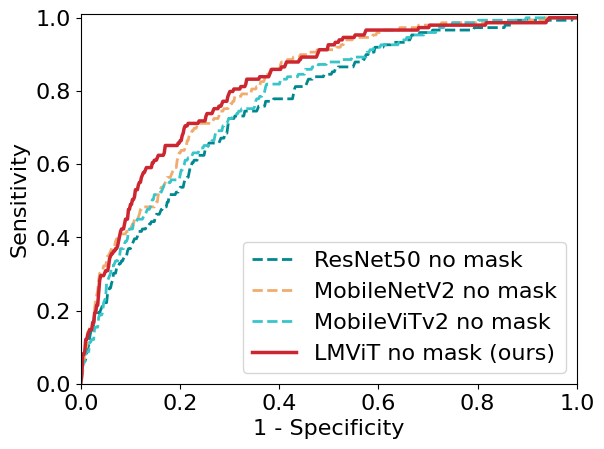

In [120]:
line_colors = ['#008891', '#F0AC6E', '#38C5C9', '#CC2630']
line_type = ['--', '--', '--', '-']
lw = [2, 2, 2, 2.5]
matplotlib.rcParams.update({'font.size': 16})
plt.figure()

color_index = 0
for idx, key in enumerate(all_curves):
    if "no mask" not in key:
        continue
    # if 'LMViT w. LN mask' in key:
    #     continue
    print(key)
    fpr_macro, tpr_macro, roc_auc_marco = all_curves[key]
    # draw
    plt.plot(
        fpr_macro,
        tpr_macro,
        color=line_colors[color_index],
        linestyle=line_type[color_index],
        lw=lw[color_index],
        label="{}".format(key),
    )
    color_index += 1

plt.xlim([0.0, 1])
plt.ylim([0.0, 1.01])
plt.xlabel("1 - Specificity")
plt.ylabel("Sensitivity")
# plt.title(f"ROC curve of CNN LNS classification")
plt.legend(loc="lower right")
# plt.show()
plt.savefig('LNM_ROC_no_mask.svg', dpi=300)

ResNet50 no mask
MobileNetV2 no mask
MobileViTv2 no mask
LMViT no mask (ours)


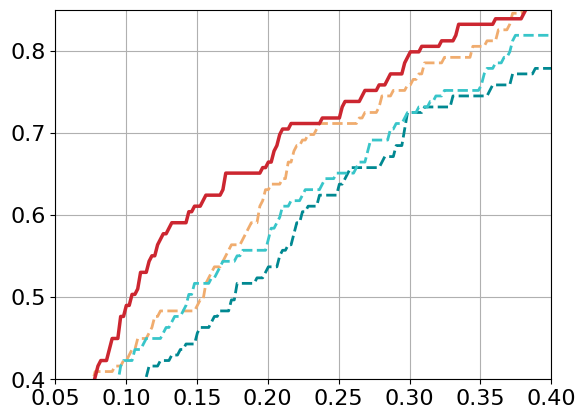

In [121]:
line_colors = ['#008891', '#F0AC6E', '#38C5C9', '#CC2630']
line_type = ['--', '--', '--', '-']
lw = [2, 2, 2, 2.5]
matplotlib.rcParams.update({'font.size': 16})
plt.figure()

color_index = 0
for idx, key in enumerate(all_curves):
    if "no mask" not in key:
        continue
    # if 'LMViT w. LN mask' in key:
    #     continue
    print(key)
    fpr_macro, tpr_macro, roc_auc_marco = all_curves[key]
    # draw
    plt.plot(
        fpr_macro,
        tpr_macro,
        color=line_colors[color_index],
        linestyle=line_type[color_index],
        lw=lw[color_index],
        label="{}".format(key),
    )
    color_index += 1

plt.xlim([0.05, 0.4])
plt.ylim([0.4, 0.85])
plt.grid()
# plt.xlabel("1 - Specificity")
# plt.ylabel("Sensitivity")
# plt.title(f"ROC curve of CNN LNS classification")
# plt.legend(loc="lower right")
# plt.show()
plt.savefig('LNM_ROC_no_mask_zoomin.svg', dpi=300)

#### Calculate PR curve

In [ ]:
# # activate latex text rendering
# plt.figure()

# color_index = 0
# for idx, key in enumerate(all_curves):
#     if "no mask" not in key:
#         continue
#     # if 'LMViT w. LN mask' in key:
#     #     continue
#     print(key)
#     fpr_macro, tpr_macro, roc_auc_marco = all_curves[key]
#     # draw
#     plt.plot(
#         fpr_macro,
#         tpr_macro,
#         color=line_colors[color_index],
#         linestyle=line_type[color_index],
#         lw=lw[color_index],
#         label="{}".format(key),
#     )
#     color_index += 1

# plt.xlim([0.0, 1])
# plt.ylim([0.0, 1.01])
# plt.xlabel("1 - Specificity")
# plt.ylabel("Sensitivity")
# # plt.title(f"ROC curve of CNN LNS classification")
# plt.legend(loc="lower right")
# # plt.show()
# plt.savefig('LNM_ROC_no_mask.png', dpi=300)

In [ ]:
# # activate latex text rendering
# plt.figure()

# color_index = 0
# for idx, key in enumerate(all_curves):
#     if "no mask" in key:
#         continue
#     # if 'LMViT w. LN mask' in key:
#     #     continue
#     print(key)
#     recall_macro, precision_macro, prc_auc_marco = all_curves[key]
#     # draw
#     if color_index == 0:
#         plt.plot(
#             recall_macro,
#             precision_macro,
#             color=line_colors[color_index],
#             linestyle=line_type[color_index],
#             lw=lw[color_index],
#             label="Ours",
            
#         )
#     elif color_index == 1:
#         plt.plot(
#             fpr_macro,
#             tpr_macro,
#             color=line_colors[color_index],
#             linestyle=line_type[color_index],
#             lw=lw[color_index],
#             label="LMViT w. LN mask (ours)",
#         )
#     else:
#         plt.plot(
#             fpr_macro,
#             tpr_macro,
#             color=line_colors[color_index],
#             linestyle=line_type[color_index],
#             lw=lw[color_index],
#             label="{}".format(key),
#         )
#     color_index += 1

# plt.xlim([0.0, 1])
# plt.ylim([0.0, 1.01])
# plt.xlabel("Recall")
# plt.ylabel("Precision")
# # plt.title(f"ROC curve of CNN LNS classification")
# plt.legend(loc="lower right")
# plt.show()